In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import fitsio

import astropy.units as u
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
from astropy.table import Table, hstack


# Set some plotting environment variables
sns.set(style='white', context='talk', palette='Set1')
plt.rcParams["font.family"] = "serif"
plt.rcParams["figure.dpi"] = 200
plt.rcParams["axes.grid.which"] = 'both'
plt.rcParams['ytick.left'] = True
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 4
plt.rcParams['ytick.major.size'] = 4
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['ytick.minor.size'] = 2

In [2]:
filedir = '/global/cfs/cdirs/desi/users/nrfran/speclens'

iron = Table(fitsio.read(os.path.join(filedir, 'iron-matches.fits')))
masterlens = Table(fitsio.read(os.path.join(filedir,'masterlens-matches.fits')))

# Let's explore the matches

In [3]:
# histogram various values

def ironHist(key, table=iron, **kwargs):
    '''
    key [str] : key that exists in the astropy Table
    table [astropy Table] : to plot from
    '''
    
    fig, ax = plt.subplots(1,1)
    
    ax.hist(table[key], color='cornflowerblue', **kwargs)
    ax.set_ylabel('N')
    ax.set_xlabel(key.lower().strip('_'))

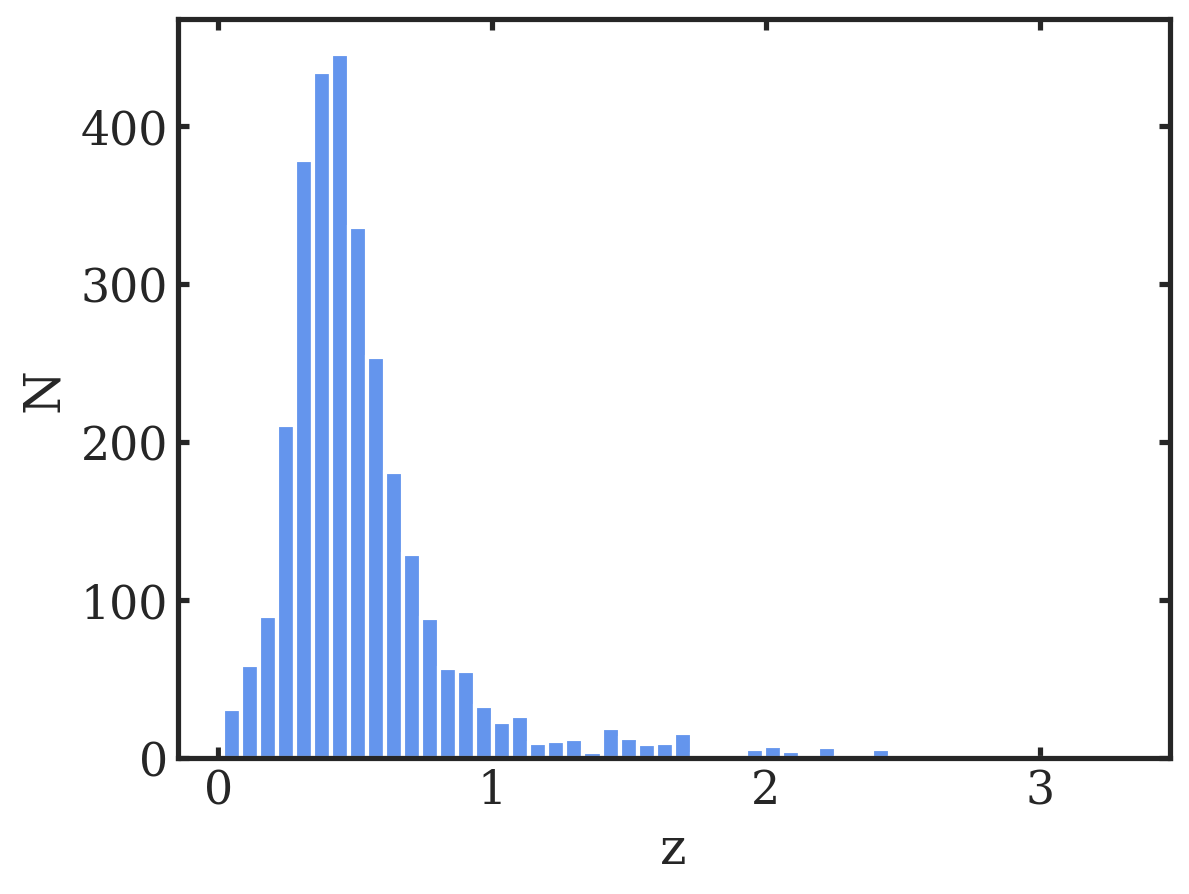

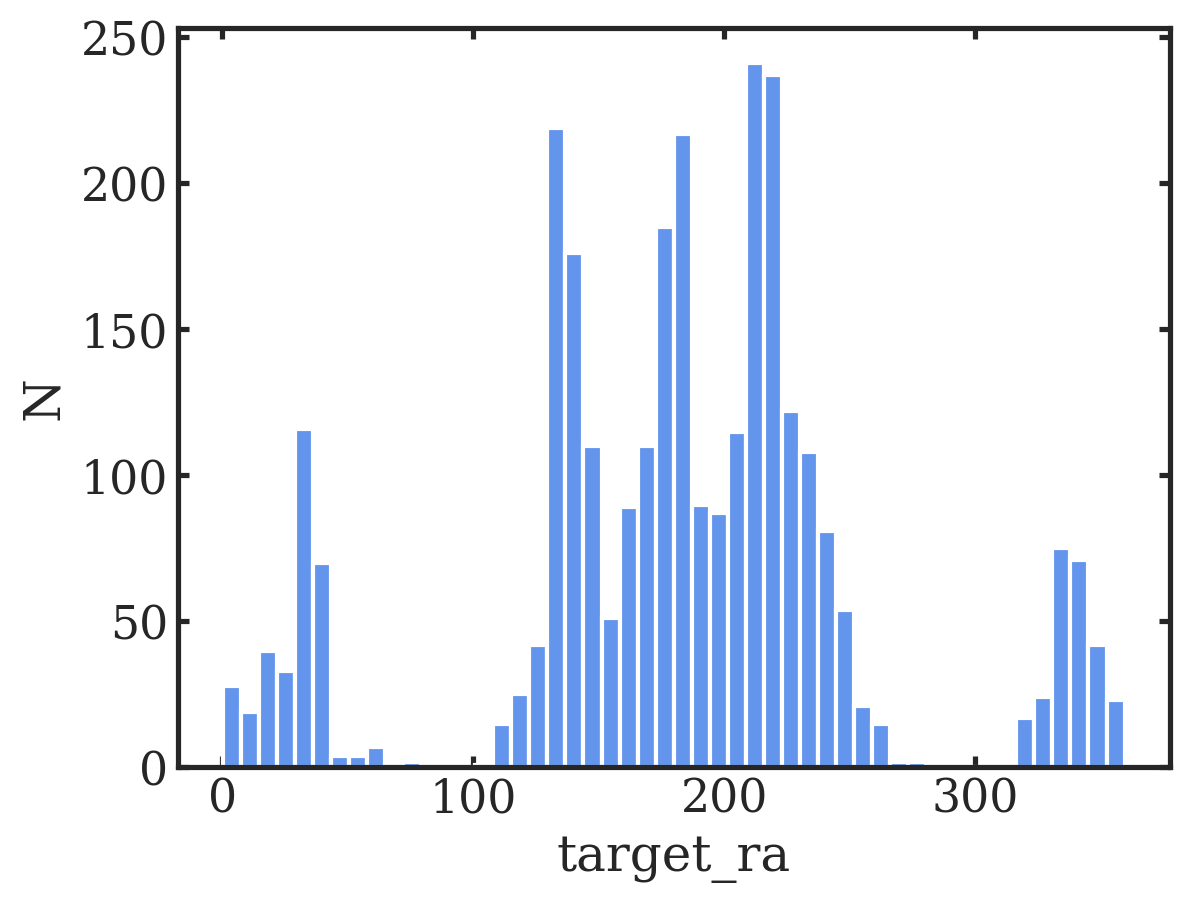

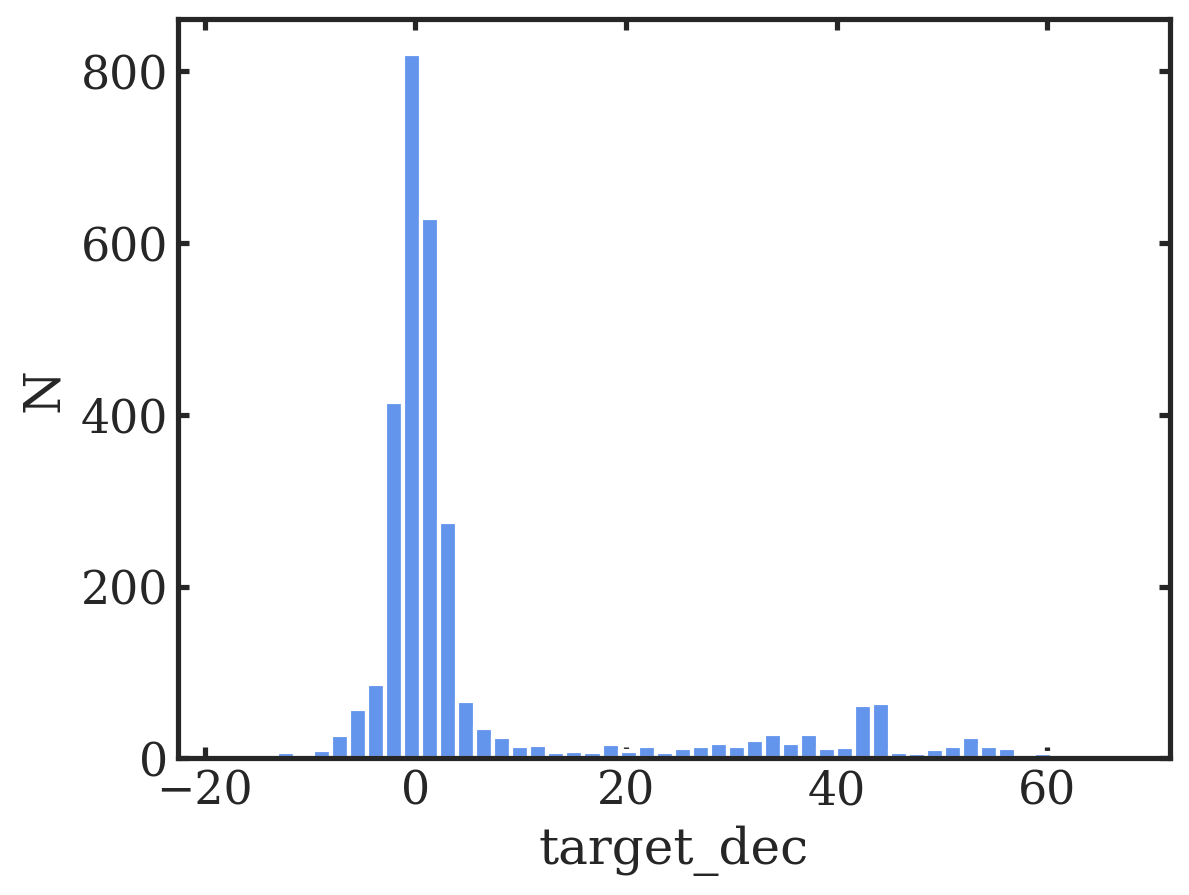

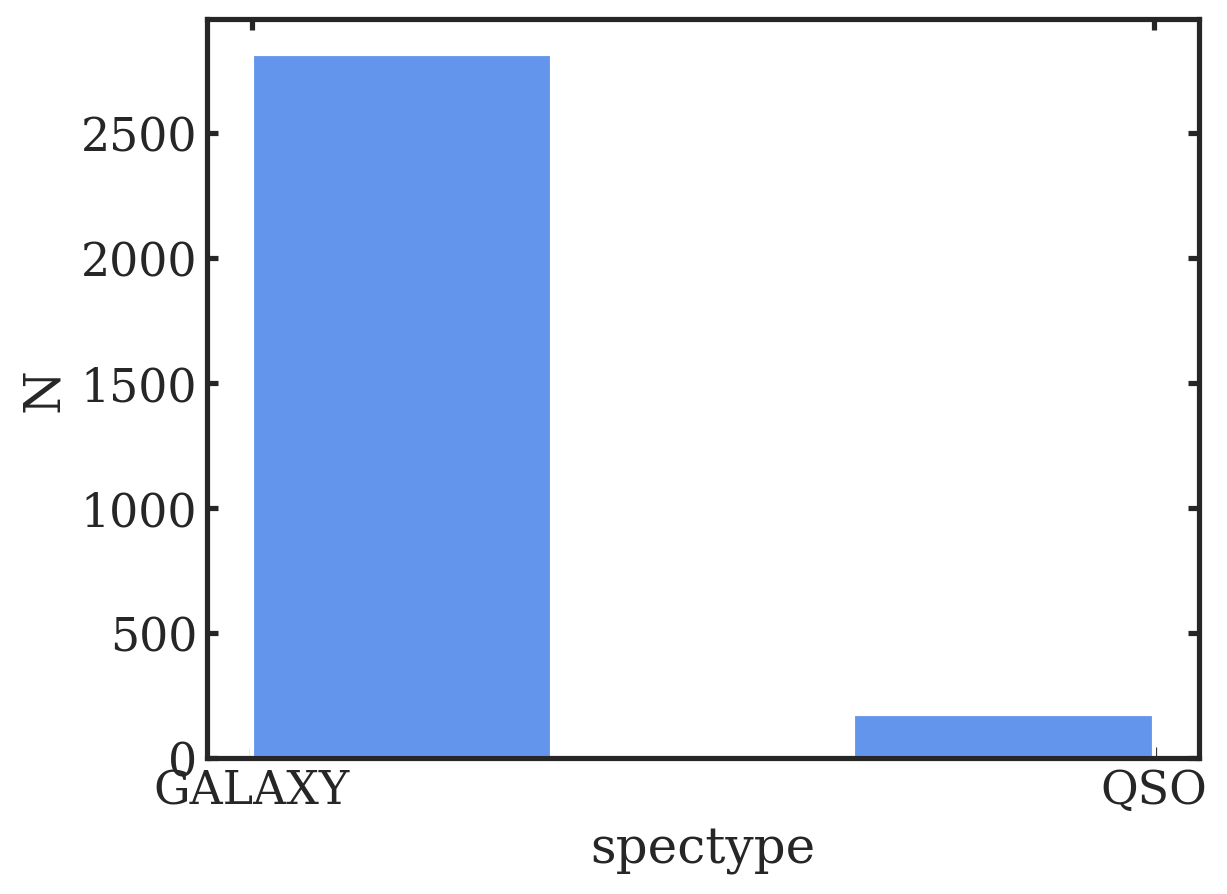

In [4]:
ironHist('Z', bins=50)
ironHist('TARGET_RA', bins=50)
ironHist('TARGET_DEC', bins=50)
ironHist('SPECTYPE', bins=3)

# Plot Skymap

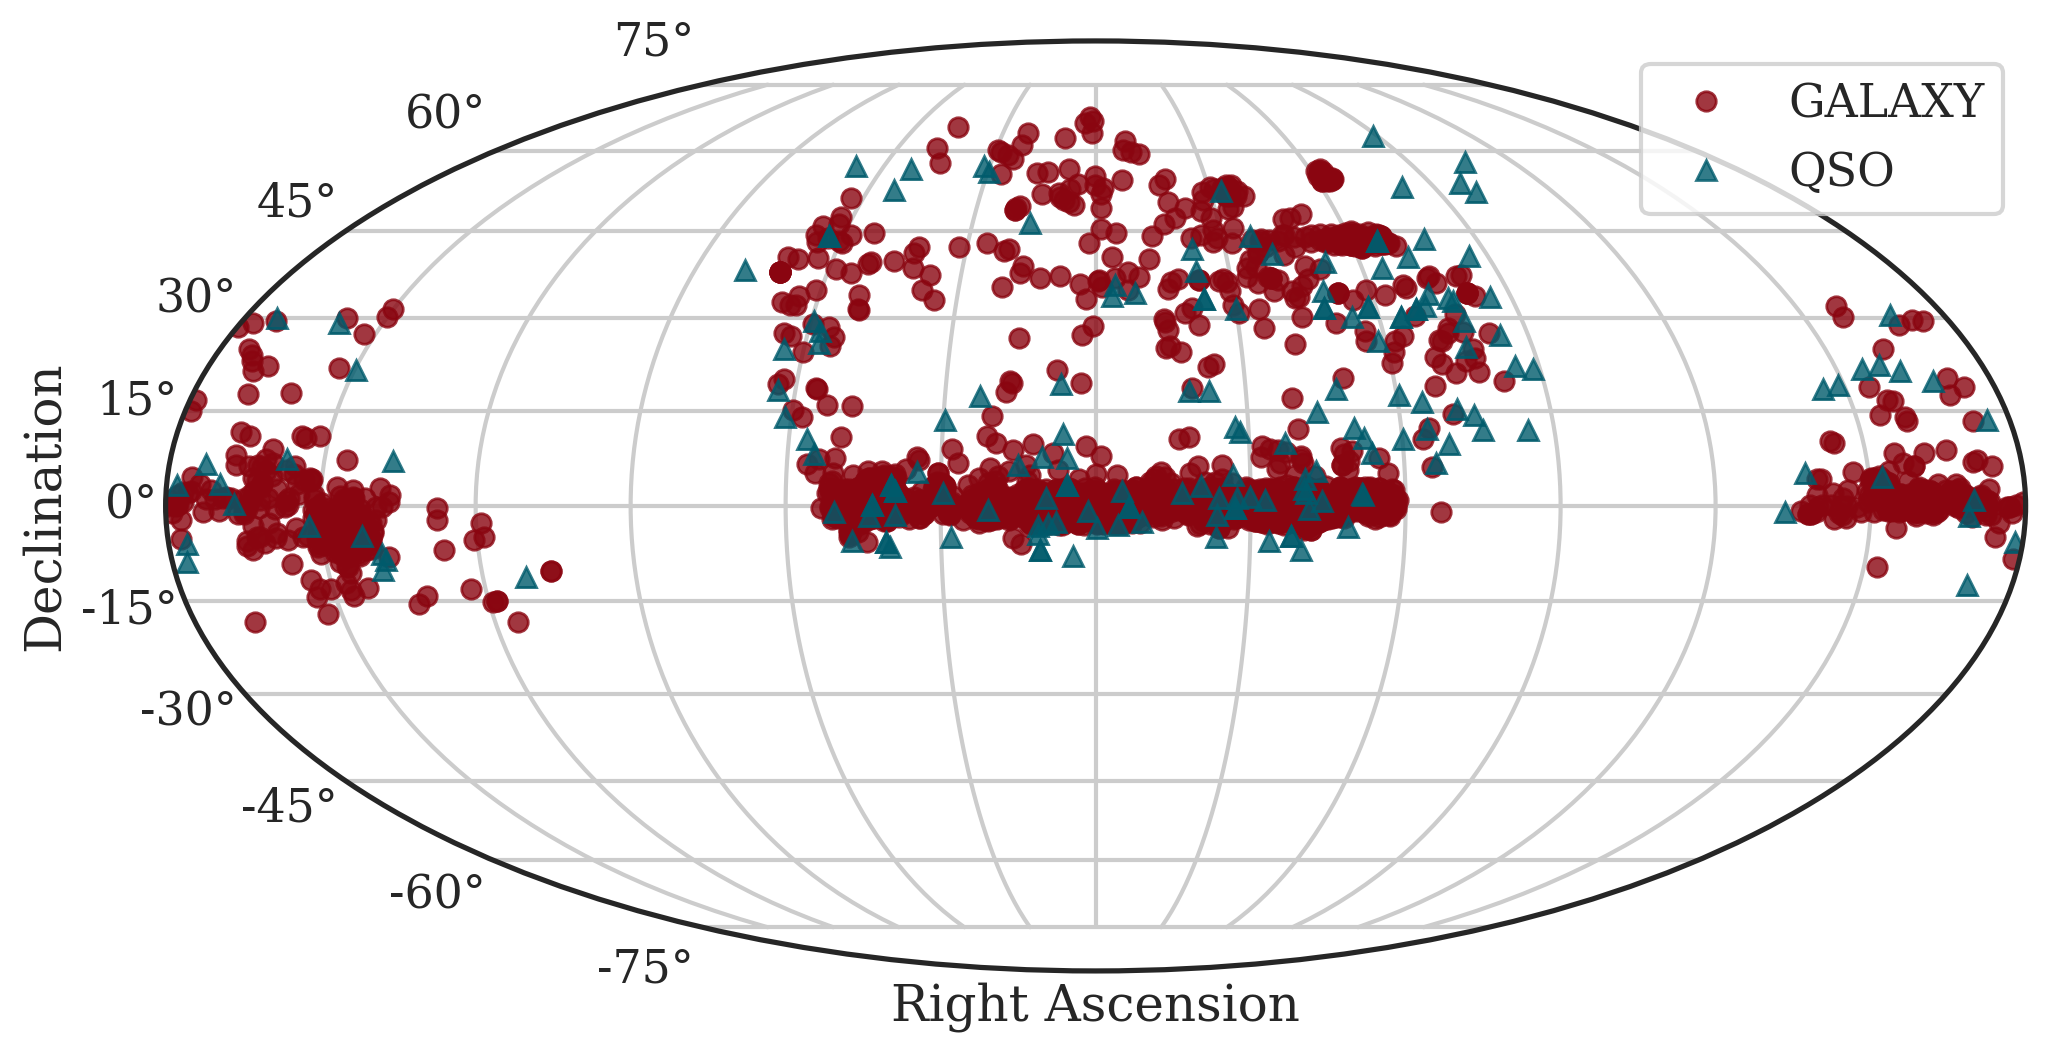

In [10]:
a = 0.8
ms = 7
key = 'SPECTYPE'#'SURVEY'

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection="mollweide")

shapes = ['o', '^', 'X', 'x', '<', '>', 'v']
colors = ['#8A0510', '#005B6C']

for val, s, c in zip(np.unique(iron[key]), shapes, colors):

    ff = iron[iron[key] == val]
    
    targRA = coord.Angle((ff['TARGET_RA']+180)*u.deg)
    targDec = coord.Angle(ff['TARGET_DEC']*u.deg)

    targRA = targRA.wrap_at(180*u.deg)

    ax.plot(targRA.radian, targDec.radian, s, label=val, zorder=2, markersize=ms, alpha=a, color=c)

ax.grid()
ax.set_xticklabels([])
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')
_=ax.legend(loc='upper right')
fig.savefig('mollweide-projection-matches.png', bbox_inches='tight', transparent=False)

In [6]:
# prep data 
sep = np.loadtxt('iron-matches-separation.txt')

print(len(sep), len(iron['Z']))

z = hstack([masterlens['Z_LENS'].astype(float), iron['Z']])
z['SEP2D'] = sep
z = z[~np.isnan(np.array(z['Z_LENS']))]

'''
# calculate separation
print(min(z['TARGET_RA']), max(z['TARGET_RA']))
print(min(z['TARGET_DEC']), max(z['TARGET_DEC']))
print(min(z['RA_COORD']), max(z['RA_COORD']))
print(min(z['DEC_COORD']), max(z['DEC_COORD']))
desiCoords = SkyCoord(z['TARGET_RA']*u.deg, z['TARGET_DEC']*u.deg)
lensCoords = SkyCoord(z['RA_COORD']*u.deg, z['DEC_COORD']*u.deg)

searchSep = 1*u.arcsec # based on the histogram, 1 arcsecond seems reasonable
sep2d = desiCoords.separation(lensCoords)
print(sep2d.unit)

z['SEP2D'] = sep2d
'''

print(f'{len(z)}/{len(iron)} objects have lens redshifts in masterlens')

2993 2993
1260/2993 objects have lens redshifts in masterlens


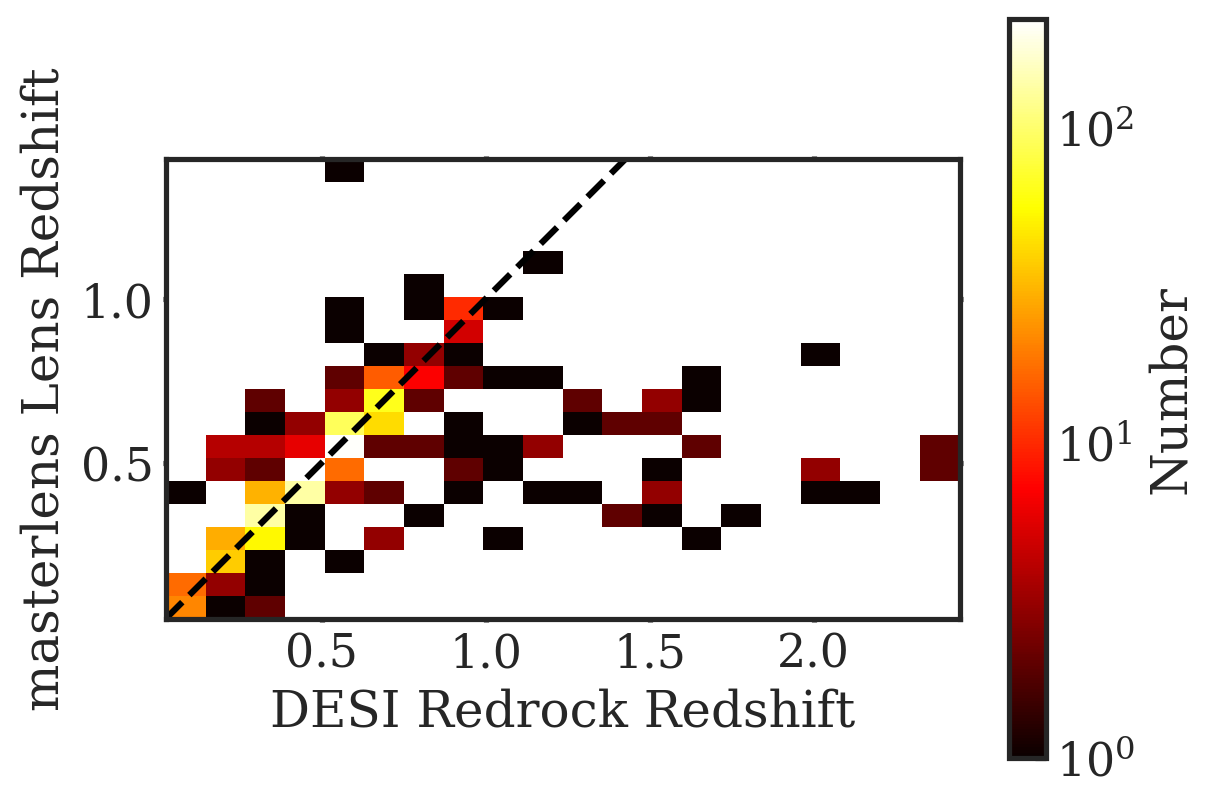

In [7]:
# compare masterlens redshifts to desi redshifts

from matplotlib.colors import LogNorm

fig, ax = plt.subplots()
#ax.plot(z['Z'], z['Z_LENS'], '.')
count, xedge, yedge, im = ax.hist2d(z['Z'], z['Z_LENS'],
                                    bins=20,
                                    cmap='hot',
                                    norm=LogNorm())
ax.set_ylabel('masterlens Lens Redshift')
ax.set_xlabel('DESI Redrock Redshift')

xy = np.linspace(np.min(z['Z']), np.max(z['Z']))
ax.plot(xy, xy, 'k--')

ax.set_aspect('equal')
ax.tick_params(axis='both',
               which='major',
               direction='out',
               length=1)
fig.colorbar(im, label='Number')
fig.savefig('redshift-comparison-2dhist.png',
            bbox_inches='tight',
            transparent=False)

Text(0.5, 0, '(DESI Z - masterlens Z) / (1 + DESI Z)')

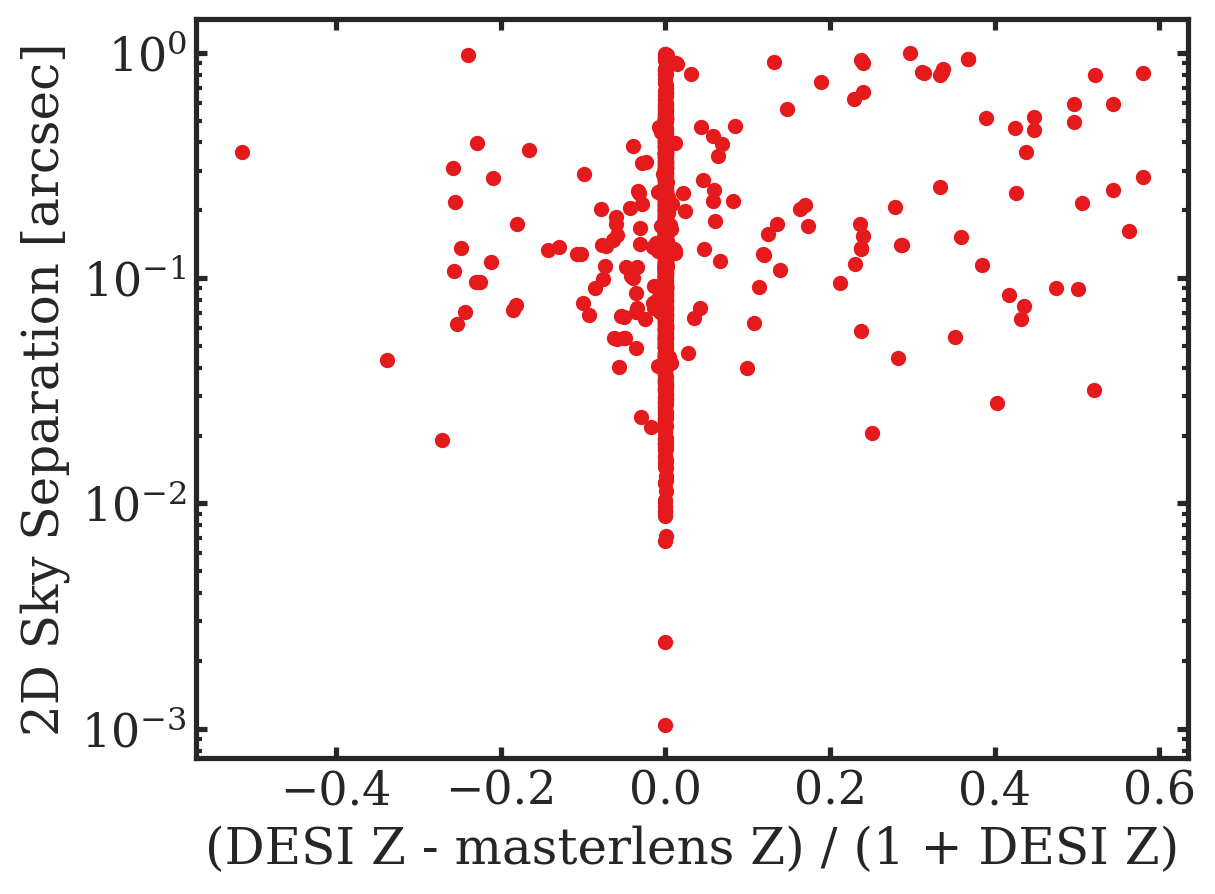

In [8]:
# investigate this further by plotting the residual redshift vs. the 2D sky separation
# Note: I say that DESI is the "truth" redshift here!!

resZ = (z['Z'] - z['Z_LENS'])/(1+z['Z']) # desi Z - masterlens Z

fig, ax = plt.subplots()
ax.plot(resZ, (z['SEP2D']*u.deg).to(u.arcsec), '.')
ax.set_yscale('log')
ax.set_ylabel('2D Sky Separation [arcsec]')
ax.set_xlabel('(DESI Z - masterlens Z) / (1 + DESI Z)')